# Shared Response Modeling
**V.0.2 - beta, [contributions](#contributions)**

What is common across different participants when performing the same task, for example watching a movie? In previous notebooks, inter-subject correlation and inter-subject functional correlation showed similarities in patterns of brain activity across subjects. We can exploit this similarity across subjects and find a common shared space where we can retain what is common across subjects. The shared response model (SRM) aims to achieve this common shared space. SRM is a functional alignment technique that maps participants into a shared, low-dimensionality feature space. Once SRM has been fit, other data from the same participants can be transformed into this space to be used as input to other analyses.

The logic of SRM is as follows: The brain data for each participant is transformed into a n voxel by t time matrix. A certain number of k features are used to learn the mapping from voxel space into this shared space S. Every voxel in the brain loads on to these k features, which means a voxel has a weight w for the k features. w is first randomly initialized and then fit over a series of iterations to minimize the error in explaining the participant data. At the same time, the time course of these k features in the shared space is learned.

If you are interested in more technical details, please refer to the [original paper](http://papers.nips.cc/paper/5855-a-reduced-dimension-fmri-shared-response-model).

![image](https://media.springernature.com/m685/nature-assets/neuro/journal/v20/n3/images/nn.4499-F4.jpg)

SRM assumes that each participant was exposed to a common sequence of events or a shared stimulus. For this reason, movies or audioclips are typically used, although experiments (e.g. face/scene discrimination) where the trials are in the same order across participants have also been used with SRM. If counterbalancing was used between participants, it is technically possible to still perform SRM by rearranging the data, although mileage may vary. For best results, the units that are counterbalanced ought to be long (e.g. >30s). 

It is also important to note that SRM needs a lot of data to train on: up to 400 TRs are necessary to get stable performance. 

## Goal of this script
    1. Learn to compute SRM.  
    2. Use SRM to determine the exact time segment that a movie clip correspond to.  
    3. Use SRM to classify across multiple datasets. Here we will train on a movie dataset and test on an image dataset.  


## Table of Contents
>[1 Data File Preparation](#data_prep_srm)  
>[2 SRM: Training data](#srm_training)  
>[3 SRM: Testing data](#srm_testing)  
>[4 Time segment matching](#time_seg)  
>[5 Image class prediction](#image_pred)

### Exercises
>[1](#ex1)   [2](#ex2)  [3](#ex3)  [4](#ex4)  [5](#ex5)  [6](#ex6)    [7](#ex7)    [8](#ex8)   
>[Novel contribution](#novel)  

In [1]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import os 

import numpy as np
from scipy import stats
import scipy.spatial.distance as sp_distance
from sklearn.svm import NuSVC

import brainiak.isfc
from brainiak.fcma.util import compute_correlation
import brainiak.funcalign.srm

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%autosave 5
%matplotlib inline

Autosaving every 5 seconds


## 1. Data File Preparation <a id="data_prep_srm"></a>

We will work on the Raider dataset in this lab. It contains Ventral Temporal Cortex (VT) voxels of 10 subjects watching movie "Raiders of the Lost Ark" and 8 runs of 7 image categories. This dataset was first used in the following publication:
Haxby, James V., J. Swaroop Guntupalli, Andrew C. Connolly, Yaroslav O. Halchenko, Bryan R. Conroy, M. Ida Gobbini, Michael Hanke, and Peter J. Ramadge. "A common, high-dimensional model of the representational space in human ventral temporal cortex." Neuron 72, no. 2 (2011): 404-416. 

In [2]:
# Set up experiment metadata
from utils import raider_data_dir
print ('Dataset directory: %s' % raider_data_dir)

# Where do you want to store the results
dir_out = os.path.expanduser('~/srm_results')
if not os.path.exists(dir_out):
    os.makedirs(dir_out)
    print('Dir %s created ' % dir_out)

Dataset directory: /home/NEU480/datasets/raider/


In [3]:
# load and inspect the shape of bold data

# load data
movie_data = np.load(os.path.join(raider_data_dir, 'movie.npy'))

# Pull out the shape data
vox_num, nTR, num_subs = movie_data.shape  

print('Participants ', num_subs)
print('Voxels per participant ', vox_num)
print('TRs per participant ', nTR)

Participants  10
Voxels per participant  1000
TRs per participant  2203


Let's separate the data into training and test sets. In this case we are going to split each participant's data down the middle, using the first half for training and the second half for testing.

In [4]:
train_data = []
test_data = []
for sub in range(num_subs):
    # Take the first half of TRs as training
    # *The double dash means integer division
    train_data.append(movie_data[:, :nTR//2, sub])  
    # Take the second half of TRs as testing
    test_data.append(movie_data[:, nTR//2:, sub])  
del movie_data

We also normalize the data, with the training and testing data normalized independently. **This results in the test data being completely separate and uncontaminated by the training data.**

In [5]:
# Iterate through the subjects
for sub in range(num_subs):    
    # Do it for training data
    train_data[sub] = stats.zscore(train_data[sub], axis=1, ddof=1)
    train_data[sub] = np.nan_to_num(train_data[sub])
    
    # Do it for test data
    test_data[sub] = stats.zscore(test_data[sub], axis=1, ddof=1)
    test_data[sub] = np.nan_to_num(test_data[sub])

## 2. SRM: training data <a id="srm_training"></a>

We are now ready to fit the data with SRM. First we create an object in BrainIAK with a specified number of features and iterations. We then fit this to our data.

Number of features should be chosen using cross-validation. In the SRM paper, 50 is chosen, so we use 50 here. Empirically, 10 or 20 iterations should be enough for the convergence of SRM.

In [6]:
features = 50  # How many features will you fit?
n_iter = 20  # How many iterations of fitting will you perform

# Create the SRM object
srm = brainiak.funcalign.srm.SRM(n_iter=n_iter, features=features)

# Fit the SRM data
print('Fitting SRM, may take a minute ...')
srm.fit(train_data)

print('SRM has been fit')

Fitting SRM, may take a minute ...
SRM has been fit


To better understand the SRM model that was just created, we can explore the newly fitted data. Let's view the time course of the shared response captured by each feature. 

SRM: Features X Time Points  (50, 1101)


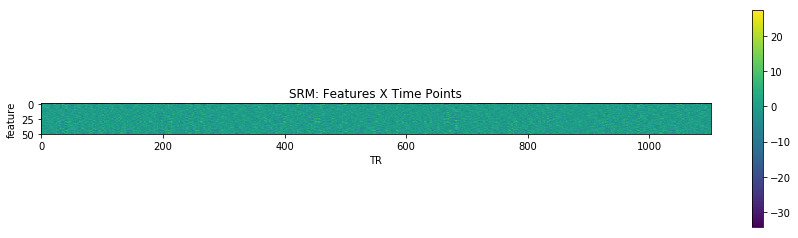

In [7]:
# Plot the shared response
print('SRM: Features X Time Points ', srm.s_.shape)
plt.figure(figsize=(15, 4))
plt.title('SRM: Features X Time Points')
plt.xlabel('TR')
plt.ylabel('feature')
plt.imshow(srm.s_, cmap='viridis')
plt.colorbar()

### 2.1 Similarity of timepoints in shared space

We can now use this shared response to estimate how similar each timepoint is to one another. We can calculate the distance between all time points in this *k* dimensional space. If the points are close to one another then that indicates that they are similar. In the case below, blue means more similar. The yellow bands indicate time points where the patterns of activity diverge, potentially reflecting a unique time point in the data.

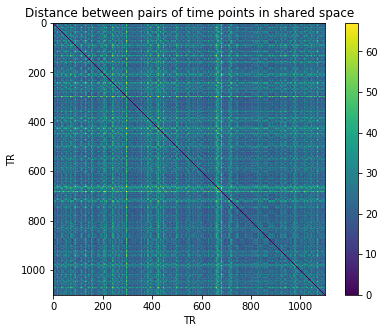

In [8]:
dist_mat = sp_distance.squareform(sp_distance.pdist(srm.s_.T))
plt.figure(figsize=(7,5))
plt.title('Distance between pairs of time points in shared space')
plt.xlabel('TR')
plt.ylabel('TR')
plt.imshow(dist_mat, cmap='viridis')
plt.colorbar()

### 2.2 The weight matrix

In addition to the shared response matrix, we now also have a $ voxels \times features $ weight matrix for each participant that specifies how to map them into the shared space. This is essentially a functional alignment transformation matrix. Let's visualize the weights associated with each feature for a given voxel.

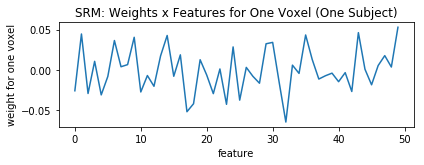

In [9]:
plt.subplot(211)
plt.title('SRM: Weights x Features for One Voxel (One Subject)')
srm.w_[0].shape
plt.plot(srm.w_[0][1,:])
plt.xlabel('feature')
plt.ylabel('weight for one voxel')
plt.tight_layout()

### 2.3 The signal is denoised: reconstructing signal in subject space

The weight matrices are not only useful for projecting new data into a shared space but also for the reverse -- reconstructing data in subject space. This reconstructed activity is denoised because only the variance that was shared across participants is in the signal, reducing any within subject noise. We reconstruct the signal in subject space with the dot product of the weights for the first participant with the shared response feature time courses.

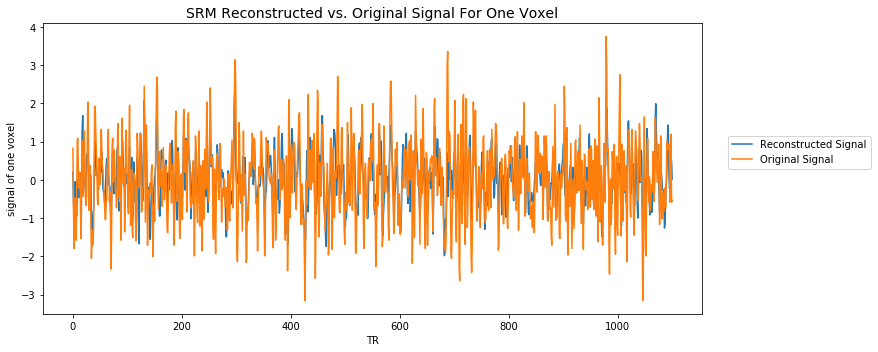

In [10]:
w0 = srm.w_[0]  # Weights for subject 1
S = srm.s_  # Shared response
signal_srm0 = w0.dot(S)  # Reconstructed signal

plt.figure(figsize=(10,5))
plt.title('SRM Reconstructed vs. Original Signal For One Voxel', fontsize=14)
plt.plot(signal_srm0[100,:])
plt.plot(train_data[0][100,:])
plt.xlabel('TR')
plt.ylabel('signal of one voxel')
plt.legend(('Reconstructed Signal', 'Original Signal'), loc=(1.04,0.5))
plt.tight_layout()

### 2.4 Projected signals have greater similarity in shared space than in subject space

We can also transform (i.e., functionally align) individual participant data into the shared space. This means that each participant is represented as a $[k  \times t] $ matrix based on what components of their brain activity was shared with other participants.

In [11]:
# Transform the SRM data into shared space
shared_train = srm.transform(train_data)

#### 2.4.1 Perform ISC on projected signals in shared space

Insofar as SRM worked, these feature time courses should be more similar across participants than the original voxel activity. We can test this with ISC: even though the shared features aren't in brain space, we can still use them as input to the ISC function.

In [12]:
# Reorganize the data back into an appropriate space for ISC
raw_obj = np.zeros((train_data[0].shape[0], train_data[0].shape[1], len(train_data)))
for ppt in range(len(train_data)):
    raw_obj[:, :, ppt] = train_data[ppt]
    
# Perform ISC on all participants, collapsing across participants    
corr_raw = brainiak.isfc.isc(raw_obj)
corr_raw = np.nan_to_num(corr_raw)  

# Reorganize the SRM transformed data back into an appropriate space for ISC
shared_obj = np.zeros((shared_train[0].shape[0], shared_train[0].shape[1], len(train_data)))
for ppt in range(len(train_data)):
    shared_obj[:, :, ppt] = shared_train[ppt]
    
# Perform ISC on all participants, collapsing across participants        
corr_shared = brainiak.isfc.isc(shared_obj)
corr_shared = np.nan_to_num(corr_shared)

Independent samples t test between raw and SRM transformed data: 40.53948971656607 p: 7.160949937210932e-217


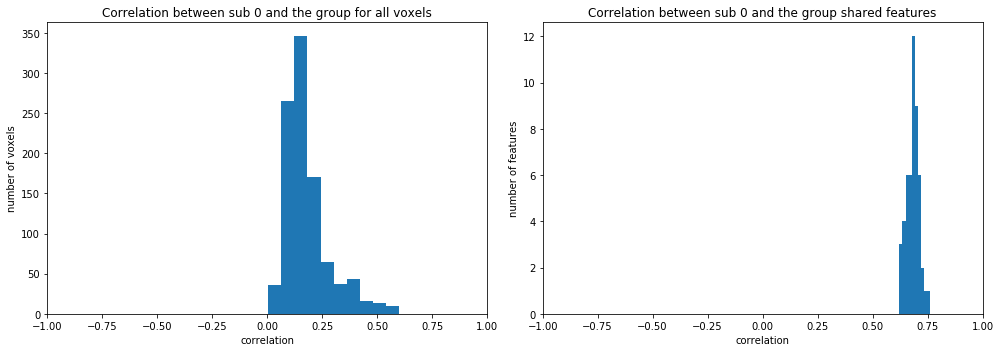

In [13]:
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
plt.title('Correlation between sub 0 and the group for all voxels')
plt.hist(corr_raw);
plt.xlabel('correlation')
plt.ylabel('number of voxels')
plt.xlim([-1, 1]);

plt.subplot(1, 2, 2)
plt.title('Correlation between sub 0 and the group shared features')
plt.hist(corr_shared);
plt.xlabel('correlation')
plt.ylabel('number of features')
plt.xlim([-1, 1]);

plt.tight_layout()

tstat = stats.ttest_ind(np.arctanh(corr_shared), np.arctanh(corr_raw))
print('Independent samples t test between raw and SRM transformed data:', tstat.statistic, 'p:', tstat.pvalue)

**Exercise 1:**<a id="ex1"></a> Why does this work so well? What's wrong and how can you fix it?

**A**: This works well because we both trained and evaluted on the train data - essentially, double-dipping. To fix this we should train on train data but evaluate on separate test data.

## 3. SRM: Test data <a id="srm_testing"></a>

We held out some data that were never seen by SRM and can use them to evaluate performance. If the dataset had other kinds of tasks (e.g., face vs. scene), we could similarly use the model to functionally align those data prior to performing other analyses (e.g., classification).

The projected test data is computed by using the weight matrices for each subject, `S'=W^T*X'`, where `X'` is the testing data. The `srm.transform` method is used for this purpose.

In [14]:
# Transform the test data into the shared space using the individual weight matrices
shared_test = srm.transform(test_data)

# Normalize data
for subject in range(num_subs):
    shared_test[subject] = stats.zscore(shared_test[subject], axis=1, ddof=1)

**Exercise 2:**<a id="ex2"></a> Repeat the analysis above in the test set, comparing ISC in the original voxel space vs. the shared feature space. Interpret your findings.

In [15]:
# Reorganize the data back into an appropriate space for ISC
raw_obj = np.zeros((test_data[0].shape[0], test_data[0].shape[1], len(test_data)))
for ppt in range(len(test_data)):
    raw_obj[:, :, ppt] = test_data[ppt]
    
# Perform ISC on all participants, collapsing across participants    
corr_raw = brainiak.isfc.isc(raw_obj)
corr_raw = np.nan_to_num(corr_raw)  

# Reorganize the SRM transformed data back into an appropriate space for ISC
shared_obj = np.zeros((shared_test[0].shape[0], shared_test[0].shape[1], len(test_data)))
for ppt in range(len(test_data)):
    shared_obj[:, :, ppt] = shared_test[ppt]
    
# Perform ISC on all participants, collapsing across participants        
corr_shared = brainiak.isfc.isc(shared_obj)
corr_shared = np.nan_to_num(corr_shared)

Independent samples t test between raw and SRM transformed data: 23.54555627795989 p: 9.809736351472046e-99


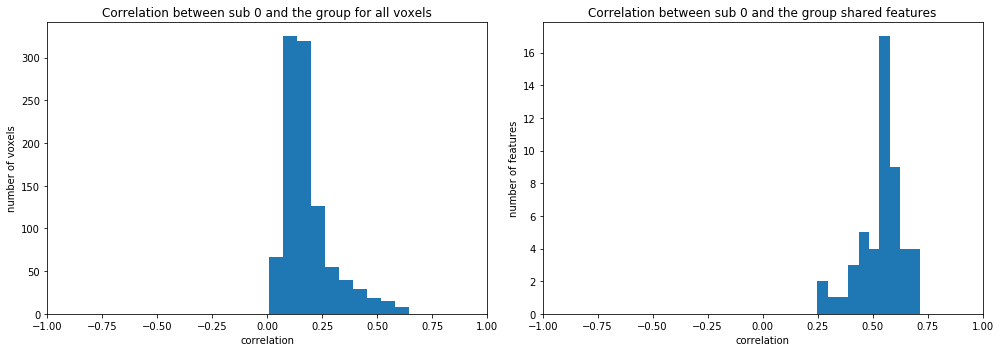

In [16]:
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
plt.title('Correlation between sub 0 and the group for all voxels')
plt.hist(corr_raw);
plt.xlabel('correlation')
plt.ylabel('number of voxels')
plt.xlim([-1, 1]);

plt.subplot(1, 2, 2)
plt.title('Correlation between sub 0 and the group shared features')
plt.hist(corr_shared);
plt.xlabel('correlation')
plt.ylabel('number of features')
plt.xlim([-1, 1]);

plt.tight_layout()

tstat = stats.ttest_ind(np.arctanh(corr_shared), np.arctanh(corr_raw))
print('Independent samples t test between raw and SRM transformed data:', tstat.statistic, 'p:', tstat.pvalue)

**A:** In both cases, the highly significant p value means the distribution of correlations is significantly different between the raw and SRM data. The correlations using shared features are much higher than those with raw data, confirming that the SRM data is more similar across participants than raw voxel activity.

**Exercise 3:** <a id="ex3"></a> In the analyses above we selected 50 features arbitrarily. This is an assumption about the dimensionality of the shared response. Try different *k* values and observe the SRM performance in the **test** set, defined as the statistical difference between raw and shared ISC. Try at least one lower and one higher value.

In [17]:
# Try k = 10
features = 10  # How many features will you fit?
n_iter = 20  # How many iterations of fitting will you perform

# Create the SRM object
srm = brainiak.funcalign.srm.SRM(n_iter=n_iter, features=features)

# Fit the SRM data
print('Fitting SRM, may take a minute ...')
srm.fit(train_data)

print('SRM has been fit')

Fitting SRM, may take a minute ...
SRM has been fit


In [18]:
# Transform the test data into the shared space using the individual weight matrices
shared_test = srm.transform(test_data)

# Normalize data
for subject in range(num_subs):
    shared_test[subject] = stats.zscore(shared_test[subject], axis=1, ddof=1)

In [19]:
# Reorganize the data back into an appropriate space for ISC
raw_obj = np.zeros((test_data[0].shape[0], test_data[0].shape[1], len(test_data)))
for ppt in range(len(test_data)):
    raw_obj[:, :, ppt] = test_data[ppt]
    
# Perform ISC on all participants, collapsing across participants    
corr_raw = brainiak.isfc.isc(raw_obj)
corr_raw = np.nan_to_num(corr_raw)  

# Reorganize the SRM transformed data back into an appropriate space for ISC
shared_obj = np.zeros((shared_test[0].shape[0], shared_test[0].shape[1], len(test_data)))
for ppt in range(len(test_data)):
    shared_obj[:, :, ppt] = shared_test[ppt]
    
# Perform ISC on all participants, collapsing across participants        
corr_shared = brainiak.isfc.isc(shared_obj)
corr_shared = np.nan_to_num(corr_shared)

Independent samples t test between raw and SRM transformed data: 16.655763155397807 p: 3.295017648450368e-55


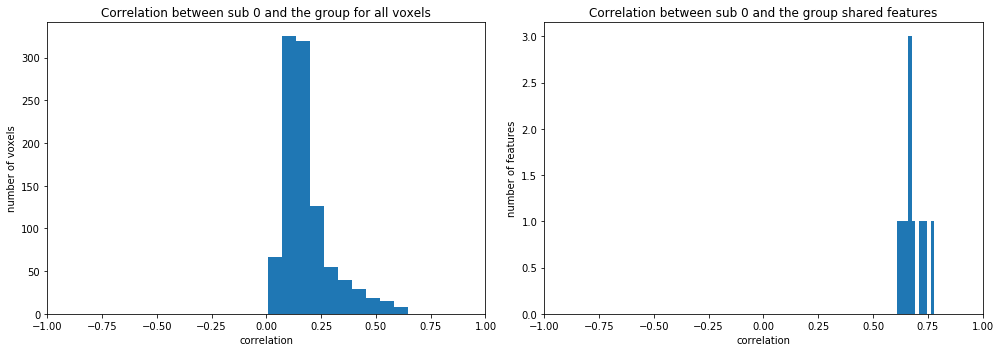

In [20]:
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
plt.title('Correlation between sub 0 and the group for all voxels')
plt.hist(corr_raw);
plt.xlabel('correlation')
plt.ylabel('number of voxels')
plt.xlim([-1, 1]);

plt.subplot(1, 2, 2)
plt.title('Correlation between sub 0 and the group shared features')
plt.hist(corr_shared);
plt.xlabel('correlation')
plt.ylabel('number of features')
plt.xlim([-1, 1]);

plt.tight_layout()

tstat = stats.ttest_ind(np.arctanh(corr_shared), np.arctanh(corr_raw))
print('Independent samples t test between raw and SRM transformed data:', tstat.statistic, 'p:', tstat.pvalue)

In [21]:
# Try k = 100
features = 100  # How many features will you fit?
n_iter = 20  # How many iterations of fitting will you perform

# Create the SRM object
srm = brainiak.funcalign.srm.SRM(n_iter=n_iter, features=features)

# Fit the SRM data
print('Fitting SRM, may take a minute ...')
srm.fit(train_data)

print('SRM has been fit')

Fitting SRM, may take a minute ...
SRM has been fit


In [22]:
# Transform the test data into the shared space using the individual weight matrices
shared_test = srm.transform(test_data)

# Normalize data
for subject in range(num_subs):
    shared_test[subject] = stats.zscore(shared_test[subject], axis=1, ddof=1)

In [23]:
# Reorganize the data back into an appropriate space for ISC
raw_obj = np.zeros((test_data[0].shape[0], test_data[0].shape[1], len(test_data)))
for ppt in range(len(test_data)):
    raw_obj[:, :, ppt] = test_data[ppt]
    
# Perform ISC on all participants, collapsing across participants    
corr_raw = brainiak.isfc.isc(raw_obj)
corr_raw = np.nan_to_num(corr_raw)  

# Reorganize the SRM transformed data back into an appropriate space for ISC
shared_obj = np.zeros((shared_test[0].shape[0], shared_test[0].shape[1], len(test_data)))
for ppt in range(len(test_data)):
    shared_obj[:, :, ppt] = shared_test[ppt]
    
# Perform ISC on all participants, collapsing across participants        
corr_shared = brainiak.isfc.isc(shared_obj)
corr_shared = np.nan_to_num(corr_shared)

Independent samples t test between raw and SRM transformed data: 25.343961669723985 p: 6.068818236472982e-112


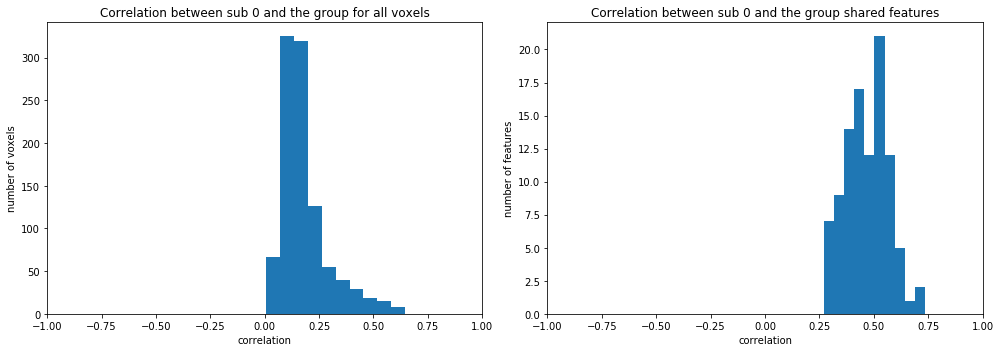

In [24]:
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
plt.title('Correlation between sub 0 and the group for all voxels')
plt.hist(corr_raw);
plt.xlabel('correlation')
plt.ylabel('number of voxels')
plt.xlim([-1, 1]);

plt.subplot(1, 2, 2)
plt.title('Correlation between sub 0 and the group shared features')
plt.hist(corr_shared);
plt.xlabel('correlation')
plt.ylabel('number of features')
plt.xlim([-1, 1]);

plt.tight_layout()

tstat = stats.ttest_ind(np.arctanh(corr_shared), np.arctanh(corr_raw))
print('Independent samples t test between raw and SRM transformed data:', tstat.statistic, 'p:', tstat.pvalue)

## 4. Time segment matching<a id="time_seg"></a>
One of the tests that has been used to quantify the benefits of SRM is *time segment matching*. This test involves taking isolated segments of fMRI data from a held-out subject and trying to determine *when in the movie* that segment occurred, by comparing the held-out segment to a whole-movie fMRI time series acquired from other subjects. So, for example, if you have a 30-second “mystery segment” of data from a held-out subject , you could compare it to all possible 30-second segments of data from the whole-movie time-series (acquired from other subjects) and see which one matches best. If the “mystery segment” matches best to the segment taken from 1:00 to 1:30 of the whole-movie time-series, that is your guess. If that guess matches the *actual* time period when the mystery segment was acquired, the guess is marked as being correct; otherwise, it is marked as being incorrect.  The whole process is shown in the figure below. The left figure shows how to learn W and test on the held-out subject and data in the time segment matching experiment. The projected test data is: `S'=W^T*X'`, where `X'` is the testing data. The right figure shows the *classifier* that is used to determine the best-matching segment (in this case, it is a max-correlation classifier). Note that the classifier computes the match to the correct segment and also all segments that *do not overlap in time* with the correct segment (segments that overlap with the correct segment are excluded, on the grounds that it might be difficult to discriminate between segments that closely overlap in time). The intuition behind time segment matching is that, if the movie fMRI time series is *well-aligned across participants and different parts of the movie have unique fMRI “signatures”* it should be possible to identify the “mystery segment” by comparing that segment to properly-timestamped fMRI timeseries from other participants. One might expect SRM to boost time-segment-matching accuracy by increasing the consistency of neural patterns across subjects. We will see below if this is the case. 

![image](srm_time_segment_matching.png)

The following sequence of steps is used to perform time segment matching:

>1. The dataset consists of all subjects watching the same movie.  
>2. The dataset is split into a training and testing set.  
>3. We fit SRM to the training data. The output is stored in `shared_train`. For comparison purposes, we can also use the raw data i.e. not fit by SRM.
>4. Pass `shared_train` to the `time_segment_matching` function.
>5. The `time_segment_matching` function performs the following steps:
>> - It creates a sliding window of size `win_size`.
>> - The time-series is broken into `nseg` overlapping windows. 
>> - Data is extracted for each of these segments.
>> - One subject is taken out for leave-one-subject-out testing. Note the input data contains all subjects. The removal of one subject from a list for cross-validation, is similar to what we have covered in previous notebooks e.g., notebook-09-fcma.
>> - A correlation is computed between the left-out subject and the average of the other subjects. This is similar to an ISC analysis. The `compute_correlation` function in BrainIAK is used to calculate this.  
>> - For each segment, the maximum correlation value is found across subjects.  
>>> - If the maximum correlation for a segment corresponds to the same segment in the test and training data, we score that as an accurate classification.  
>> - The final accuracy of the classifier is returned for all subjects.

In [25]:
# Take in a list of participants of voxel by TR data. Also specify how big the time segment is to be matched
def time_segment_matching(data, win_size=10): 
    nsubjs = len(data)
    (ndim, nsample) = data[0].shape
    accu = np.zeros(shape=nsubjs)
    nseg = nsample - win_size 
    # mysseg prediction prediction
    trn_data = np.zeros((ndim*win_size, nseg),order='f')
    # the trn data also include the tst data, but will be subtracted when calculating A
    for m in range(nsubjs):
        for w in range(win_size):
            trn_data[w*ndim:(w+1)*ndim,:] += data[m][:,w:(w+nseg)]
    for tst_subj in range(nsubjs):
        tst_data = np.zeros((ndim*win_size, nseg),order='f')
        for w in range(win_size):
            tst_data[w*ndim:(w+1)*ndim,:] = data[tst_subj][:,w:(w+nseg)]

        A =  np.nan_to_num(stats.zscore((trn_data - tst_data),axis=0, ddof=1))
        B =  np.nan_to_num(stats.zscore(tst_data,axis=0, ddof=1))

        # compute correlation matrix
        corr_mtx = compute_correlation(B.T,A.T)

        # The correlation classifier.
        for i in range(nseg):
            for j in range(nseg):
                # exclude segments overlapping with the testing segment
                if abs(i-j)<win_size and i != j :
                    corr_mtx[i,j] = -np.inf
        max_idx =  np.argmax(corr_mtx, axis=1)
        accu[tst_subj] = sum(max_idx == range(nseg)) / nseg

        # Print accuracy
        print("Accuracy for subj %d is: %0.4f" % (tst_subj, accu[tst_subj] ))
        
    print("The average accuracy among all subjects is {0:f} +/- {1:f}".format(np.mean(accu), np.std(accu)))
    return accu

In [55]:
# Run for voxel data
accu_train_r = time_segment_matching(train_data, win_size=10)

Accuracy for subj 0 is: 0.1237
Accuracy for subj 1 is: 0.1366
Accuracy for subj 2 is: 0.0449
Accuracy for subj 3 is: 0.1842
Accuracy for subj 4 is: 0.1595
Accuracy for subj 5 is: 0.0871
Accuracy for subj 6 is: 0.1485
Accuracy for subj 7 is: 0.1586
Accuracy for subj 8 is: 0.1008
Accuracy for subj 9 is: 0.2007
The average accuracy among all subjects is 0.134464 +/- 0.044484


**Exercise 4:**<a id="ex4"></a> The results above show that trying to determine a time segment from raw data is quite difficult. Note that 13% is not too bad since the chance accuracy is *1/number of segments = 1/1082= 0.09%*, but let's see if we can do better with SRM. Use SRM to transform the data and discover how it improves the identification of time segments.

In [28]:
# Create the SRM object
srm = brainiak.funcalign.srm.SRM(n_iter=20, features=50)
srm.fit(train_data)
shared_train = srm.transform(train_data)

accu_train_s = time_segment_matching(shared_train, win_size=10)

Accuracy for subj 0 is: 0.9844
Accuracy for subj 1 is: 0.9973
Accuracy for subj 2 is: 0.9184
Accuracy for subj 3 is: 0.9991
Accuracy for subj 4 is: 0.9991
Accuracy for subj 5 is: 0.9798
Accuracy for subj 6 is: 1.0000
Accuracy for subj 7 is: 0.9963
Accuracy for subj 8 is: 1.0000
Accuracy for subj 9 is: 1.0000
The average accuracy among all subjects is 0.987443 +/- 0.023979


**Exercise 5:**<a id="ex5"></a> Perform time segment matching on both raw and SRM transformed test data. Make a plot of the accuracies for 4 conditions: raw training data, transformed training data, raw testing data, transformed testing data. Plot the average with error bar.

In [29]:
# Insert code here
accu_test_r = time_segment_matching(test_data, win_size=10)

shared_test = srm.transform(test_data)
accu_test_s = time_segment_matching(shared_test, win_size=10)

Accuracy for subj 0 is: 0.1667
Accuracy for subj 1 is: 0.1172
Accuracy for subj 2 is: 0.0833
Accuracy for subj 3 is: 0.1767
Accuracy for subj 4 is: 0.1529
Accuracy for subj 5 is: 0.1200
Accuracy for subj 6 is: 0.0998
Accuracy for subj 7 is: 0.1429
Accuracy for subj 8 is: 0.1255
Accuracy for subj 9 is: 0.1712
The average accuracy among all subjects is 0.135623 +/- 0.029965
Accuracy for subj 0 is: 0.9020
Accuracy for subj 1 is: 0.7271
Accuracy for subj 2 is: 0.7537
Accuracy for subj 3 is: 0.9478
Accuracy for subj 4 is: 0.8599
Accuracy for subj 5 is: 0.8342
Accuracy for subj 6 is: 0.8974
Accuracy for subj 7 is: 0.7995
Accuracy for subj 8 is: 0.8562
Accuracy for subj 9 is: 0.9597
The average accuracy among all subjects is 0.853755 +/- 0.073307


In [56]:
df = pd.DataFrame(data=np.append(accu_train_r, [accu_train_s, accu_test_r, accu_test_s]), columns=['Accuracy'])
df['Condition'] = ""
df.loc[:10, 'Condition'] = 'Train Raw'
df.loc[10:20, 'Condition'] = 'Train SRM'
df.loc[20:30, 'Condition'] = 'Test Raw'
df.loc[30:40, 'Condition'] = 'Test SRM'

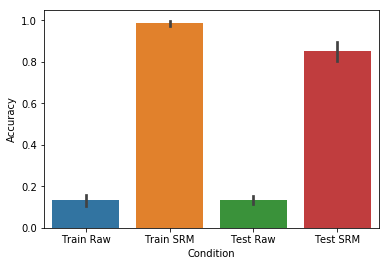

In [57]:
sns.barplot(data=df, x='Condition', y='Accuracy')

**Exercise 6:**<a id="ex6"></a> How does the number of subjects used to fit SRM impact the performance? Fit SRMs on different number of subjects and run time segment matching. Start from 2 subjects. Plot average accuracy across subjects vs. number of subjects used to fit SRM. For example, train an SRM on subject 1 and 2 and test it on subject 1 and 2 and output the average accuracy; train an SRM on subject 1,2,3 and test it on subject 1,2,3 and output the average accuracy, etc.

In [60]:
# Try using 2 to 10 subjects

accs = []

for n in range(2,11):
    train_subset = train_data[:n]
    test_subset = test_data[:n]
    
    srm = brainiak.funcalign.srm.SRM(n_iter=20, features=50)
    srm.fit(train_subset)
    shared_test = srm.transform(test_subset)
    acc = time_segment_matching(shared_test, win_size=10)
    
    accs.append(np.mean(acc))

Accuracy for subj 0 is: 0.3892
Accuracy for subj 1 is: 0.3864
The average accuracy among all subjects is 0.387821 +/- 0.001374
Accuracy for subj 0 is: 0.5742
Accuracy for subj 1 is: 0.5119
Accuracy for subj 2 is: 0.5229
The average accuracy among all subjects is 0.536325 +/- 0.027138
Accuracy for subj 0 is: 0.7784
Accuracy for subj 1 is: 0.6035
Accuracy for subj 2 is: 0.6200
Accuracy for subj 3 is: 0.7995
The average accuracy among all subjects is 0.700321 +/- 0.089102
Accuracy for subj 0 is: 0.8214
Accuracy for subj 1 is: 0.6300
Accuracy for subj 2 is: 0.6593
Accuracy for subj 3 is: 0.8837
Accuracy for subj 4 is: 0.7793
The average accuracy among all subjects is 0.754762 +/- 0.096263
Accuracy for subj 0 is: 0.8297
Accuracy for subj 1 is: 0.6795
Accuracy for subj 2 is: 0.6978
Accuracy for subj 3 is: 0.9194
Accuracy for subj 4 is: 0.8013
Accuracy for subj 5 is: 0.7637
The average accuracy among all subjects is 0.781899 +/- 0.081095
Accuracy for subj 0 is: 0.8526
Accuracy for subj 1 is: 

Text(0,0.5,'Test accuracy')

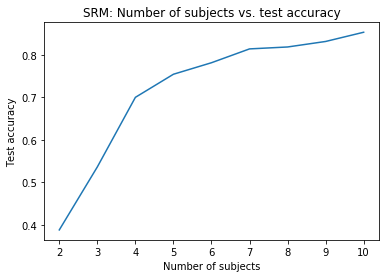

In [64]:
plt.plot(range(2,11), accs)
plt.title('SRM: Number of subjects vs. test accuracy')
plt.xlabel('Number of subjects')
plt.ylabel('Test accuracy')

## 5. Image class prediction<a id="image_pred"></a>

We have shown that cross-subject alignment (as measured, e.g., by time-segment matching) can be improved when SRM is trained on movie data and then tested on movie data. This shows that the shared space learned on movie data transfers well to *other movie data*. An important question is whether this shared space is only useful for movie data, or whether it generalizes to other kinds of data -- put another way, should we think of the shared space obtained from movie data as being a general purpose shared space that can be used to align other kinds of experiences (e.g., viewing static images), or is it a *specialized* space that can only be used to align movies? Here, we will address this question by training SRM on movie data and then applying the trained model to a different experiment (run in the same participants) where participants viewed static images from different categories. If we observe that SRM improves across-subject classification of image category (from the static-image-viewing experiment), this would suggest that the shared space learned by SRM is applicable more broadly to other visual experiments (not just to other movies). 

Note that the classification procedure here is basically the same as other image-classification analyses that we ran in previous notebooks. The main difference is that we are leaving out one subject (i.e., we are doing cross-subject classification) instead of doing within-subject classification. First, we will fit SRM (based on movie data), apply the transformation to the image-viewing data, and compute cross-subject classification using an SVM. Next, we will try the same cross-subject classification procedure without SRM. 

In [16]:
# Run a leave-one-out cross validation with the subjects
def image_class_prediction(image_data_shared, labels):
    subjects = len(image_data_shared)
    train_labels = np.tile(labels, subjects-1)
    test_labels = labels
    accuracy = np.zeros((subjects,))
    for subject in range(subjects):
        # Concatenate the subjects' data for training into one matrix
        train_subjects = list(range(subjects))
        train_subjects.remove(subject)
        TRs = image_data_shared[0].shape[1]
        train_data = np.zeros((image_data_shared[0].shape[0], len(train_labels)))
        for train_subject in range(len(train_subjects)):
            start_index = train_subject*TRs
            end_index = start_index+TRs
            train_data[:, start_index:end_index] = image_data_shared[train_subjects[train_subject]]

        # Train a Nu-SVM classifier using scikit learn
        classifier = NuSVC(nu=0.5, kernel='linear')
        classifier = classifier.fit(train_data.T, train_labels)

        # Predict on the test data
        predicted_labels = classifier.predict(image_data_shared[subject].T)
        accuracy[subject] = sum(predicted_labels == test_labels)/len(predicted_labels)
        # Print accuracy
        print("Accuracy for subj %d is: %0.4f" % (subject, accuracy[subject] ))
        
    print("The average accuracy among all subjects is {0:f} +/- {1:f}".format(np.mean(accuracy), np.std(accuracy)))
    return accuracy

**Exercise 7:**<a id="ex7"></a> Fit an SRM with movie data and perform the image class prediction experiment on the transformed image data. Use features=100.

In [17]:
# Insert code here
# Load movie data as training
movie_data = np.load(os.path.join(raider_data_dir, 'movie.npy'))

# Load image data and labels as testing
image_data = np.load(os.path.join(raider_data_dir, 'image.npy'))
labels = np.load(os.path.join(raider_data_dir, 'label.npy'))

# convert to list
train_data = []
test_data = []
for sub in range(num_subs):
    train_data.append(movie_data[:,:,sub])  
    test_data.append(image_data[:,:,sub])  
del movie_data, image_data

# Zscore training and testing data
for sub in range(num_subs):    
    # Do it for training data
    train_data[sub] = stats.zscore(train_data[sub], axis=1, ddof=1)
    train_data[sub] = np.nan_to_num(train_data[sub])
    
    # Do it for test data
    test_data[sub] = stats.zscore(test_data[sub], axis=1, ddof=1)
    test_data[sub] = np.nan_to_num(test_data[sub])
    
# Create the SRM object
srm = brainiak.funcalign.srm.SRM(n_iter=20, features=100)

# Fit the SRM data
srm.fit(train_data)

# Transform the test data into the shared space using the individual weight matrices
shared_test = srm.transform(test_data)

# Normalize data
for sub in range(num_subs):
    shared_test[sub] = stats.zscore(shared_test[sub], axis=1, ddof=1)
    shared_test[sub] = np.nan_to_num(shared_test[sub])

# run the experiment
acc_s = image_class_prediction(shared_test, labels)

Accuracy for subj 0 is: 0.7321
Accuracy for subj 1 is: 0.6964
Accuracy for subj 2 is: 0.6429
Accuracy for subj 3 is: 0.6250
Accuracy for subj 4 is: 0.6607
Accuracy for subj 5 is: 0.6071
Accuracy for subj 6 is: 0.6786
Accuracy for subj 7 is: 0.5893
Accuracy for subj 8 is: 0.5000
Accuracy for subj 9 is: 0.6071
The average accuracy among all subjects is 0.633929 +/- 0.061471


**Exercise 8:**<a id="ex8"></a> Run the image class prediction experiment on the raw (z-scored but not transformed by SRM) image data and compare the results with Exercise 5.

In [70]:
# Insert code here
acc_r = image_class_prediction(test_data, labels)

Accuracy for subj 0 is: 0.3393
Accuracy for subj 1 is: 0.4464
Accuracy for subj 2 is: 0.2321
Accuracy for subj 3 is: 0.2679
Accuracy for subj 4 is: 0.3036
Accuracy for subj 5 is: 0.2143
Accuracy for subj 6 is: 0.2143
Accuracy for subj 7 is: 0.2321
Accuracy for subj 8 is: 0.2500
Accuracy for subj 9 is: 0.2500
The average accuracy among all subjects is 0.275000 +/- 0.068325


**A**: Raw accuracy is still worse than SRM, as in Ex 5, but the difference in prediction accuracy between the two is less extreme.

### 6. SRM in comparison to other methods

If you would like to see how SRM compares to other methods such as hyperalignment and canonical correlation analysis, refer to the supplementary section here: https://papers.nips.cc/paper/5855-a-reduced-dimension-fmri-shared-response-model

**Novel contribution:** <a id="novel"></a> be creative and make one new discovery by adding an analysis, visualization, or optimization.

**Some ideas for novel contribution:** 
- Use cross-validation to select the best number of features in time segment matching or image class prediction experiments.
- Explore the effect of different number of TRs in the training set.

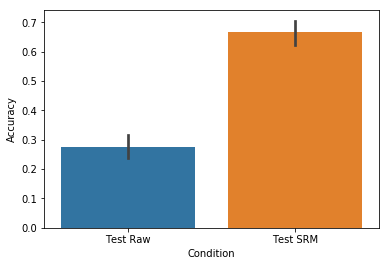

In [71]:
# plot the raw vs. SRM accuracies for image class prediction experiment
# plot means and error bars by condition

df = pd.DataFrame(data=np.append(acc_r, acc_s), columns=['Accuracy'])
df['Condition'] = ""
df.loc[:10, 'Condition'] = 'Test Raw'
df.loc[10:20, 'Condition'] = 'Test SRM'

sns.barplot(data=df, x='Condition', y='Accuracy')

## Contributions <a id="contributions"></a>
M. Kumar, C. Ellis and N. Turk-Browne produced the initial notebook 4/4/18  
C. Chen provided initial code  
H. Zhang major edits, added more exercises, added image class prediction section, filled in solutions, processed raider dataset, novel contribution ideas.  
M. Kumar edited sections and added details to the time-segment matching function.